In [10]:
import pandas as pd
import numpy as np
from numpy.core.umath_tests import inner1d
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from utils import *
from plot_functions import bland_altman_plot, plot_data 

# Set aSBP as the prediction variable
prediction_variable = 'aSBP'  

# Select regression method, e.g., 'RF','SVR','RIDGE','GB'
regressor = 'SVR'       

# Enable figure saving
save_figure_boolean = False 

experiment_type = 'invivo'    # Set the type of data being used in the analysis

# Load Data

In [2]:
invivo_dataset = pd.read_csv('invivo_data.csv')
insilico_dataset = pd.read_csv('insilico_data.csv')
# insilico_dataset.head()

# Regression Analysis

## Validation of an in vivo trained SVR using in vivo data

In [3]:
# - Seperate attributes and prediction values
X = invivo_dataset.iloc[:,invivo_dataset.columns.get_loc('brSBP'):-1].values
y = invivo_dataset.iloc[:,-1].values
# save_input_output_pairs(X,y)

# X,y = load_input_output_pairs()

In [4]:
# k-fold Cross-validation
k = 10
kf = KFold(n_splits=k); kf.get_n_splits(X); print(kf); KFold(n_splits=k, random_state=None, shuffle=False)

current_fold = 0;
y_pred_total = None; y_test_total = None;
metrics_array = np.empty((k, 4))


for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # model, y_pred, hyper_parameters = hyperparameter_tuning(X_train, X_test, y_train, y_test,regressor)
    model, y_pred = run_regressor_with_best_hyperparams(X_train, X_test, y_train, y_test, regressor, prediction_variable)
    
    output_verbose = False
    metrics_array = calculate_metrics_for_each_fold(current_fold,y_test,y_pred,metrics_array,output_verbose)
    current_fold = current_fold + 1
    
    y_test_total, y_pred_total = accumulate_predictions(y_test, y_pred, current_fold, y_test_total, y_pred_total)
    
    

KFold(n_splits=10, random_state=None, shuffle=False)


### Print Results

In [5]:
calculate_regression_statistics(y_test_total, y_pred_total, metrics_array, regressor)

+-------+-------+-----------+------------------+---------+-----------+----------+-----------------+---------------+
| Model | Slope | Intercept | Correlation Coef | p-value |    RMSE   |  nRMSE   | Mean difference | SD difference |
+-------+-------+-----------+------------------+---------+-----------+----------+-----------------+---------------+
|  SVR  |  1.0  |    0.31   |       0.97       |   0.0   | 3.53±1.27 | 5.26±2.3 |       0.18      |      3.74     |
+-------+-------+-----------+------------------+---------+-----------+----------+-----------------+---------------+
p-value: 0.0
Average MAE: 2.74
SD MAE: 1.14


### Plot Results

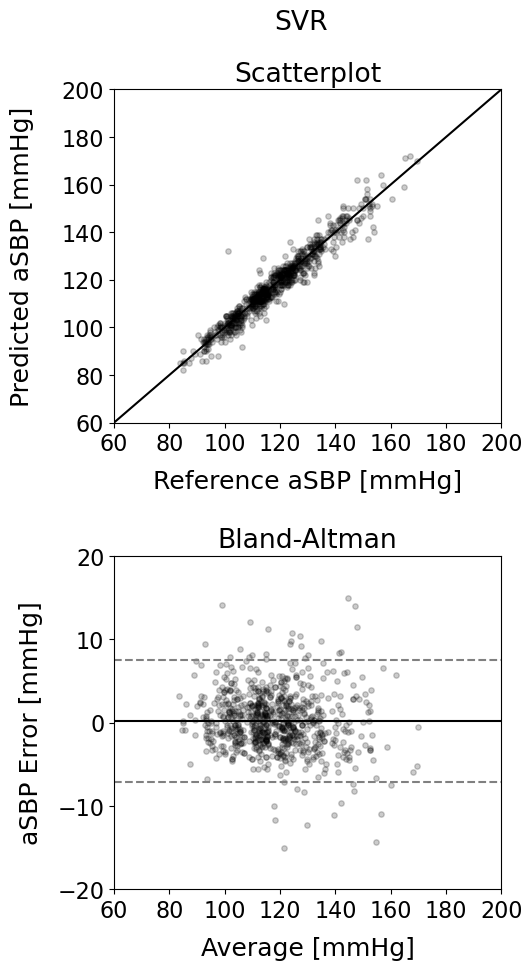

Bias: 0.18 mmHg
Upper LoA: 7.52 mmHg
Lower LoA: -7.16 mmHg


In [6]:
plot_data(y_test_total, y_pred_total, experiment_type, prediction_variable, regressor, save_figure_boolean)

## Validation of an in silico trained SVR using in vivo data

In [7]:
X_train = insilico_dataset[['brSBP','brDBP','cfPWV','HR']].values
y_train = insilico_dataset[['aSBP']].values

X_test = invivo_dataset[['brSBP','brDBP','cfPWV','HR']].values
y_test = invivo_dataset[['aSBP']].values.flatten()

metrics_array = np.empty((1, 4))
model, y_pred = run_regressor_with_best_hyperparams(X_train, X_test, y_train, y_test, regressor, prediction_variable)
output_verbose = False
metrics_array = calculate_metrics_for_each_fold(0,y_test, y_pred,metrics_array,output_verbose)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Print Results

In [8]:
calculate_regression_statistics(y_test, y_pred, metrics_array, regressor)

+-------+-------+-----------+------------------+---------+----------+---------+-----------------+---------------+
| Model | Slope | Intercept | Correlation Coef | p-value |   RMSE   |  nRMSE  | Mean difference | SD difference |
+-------+-------+-----------+------------------+---------+----------+---------+-----------------+---------------+
|  SVR  |  0.98 |    5.36   |       0.92       |   0.0   | 6.57±0.0 | 7.3±0.0 |      -3.03      |      5.83     |
+-------+-------+-----------+------------------+---------+----------+---------+-----------------+---------------+
p-value: 0.0
Average MAE: 5.04
SD MAE: 0.0


### Plots Results

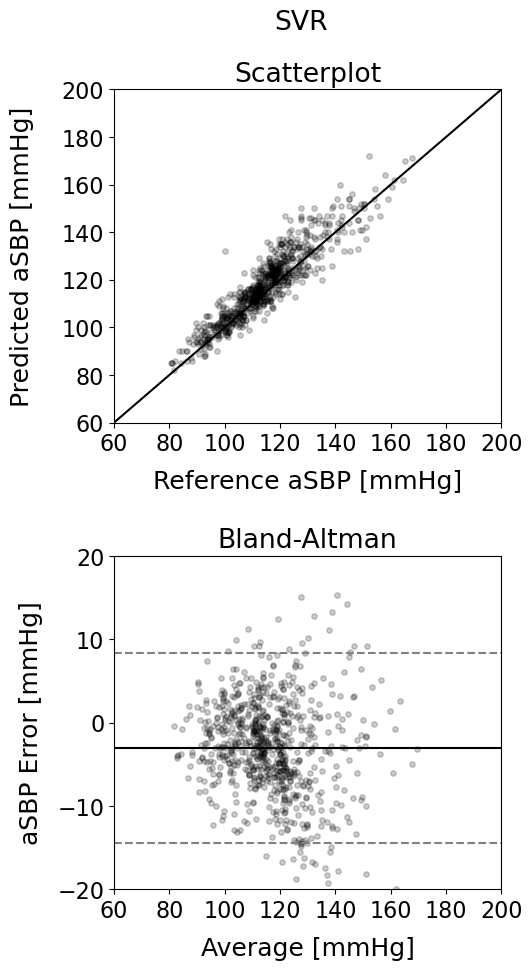

Bias: -3.03 mmHg
Upper LoA: 8.41 mmHg
Lower LoA: -14.47 mmHg


In [9]:
plot_data(y_test, y_pred, experiment_type, prediction_variable, regressor, save_figure_boolean)